### Clean Scraped Data

In [1]:
import os
import time
import csv
import pandas as pd
import re
import html  # unescaping
from datetime import datetime

df = pd.read_parquet("raw_reddit_comments.parquet")

def clean_text(t):
    t = str(t)
    t = html.unescape(t)  # Unescape HTML entities (e.g., &amp; -> &)
    t = re.sub(r"<[^>]+>", "", t)  # Strip HTML tags
    t = re.sub(r"\*\*?\*?", "", t)  # Basic markdown bold/italic
    t = re.sub(r"`{1,3}.*?`{1,3}", "", t, flags=re.DOTALL)  # Code blocks
    t = re.sub(r"http\S+", "", t)  # URLs
    t = re.sub(r"\s+", " ", t)  # Collapse whitespace
    t = t.strip()
    return t

df['cleaned'] = df['comment_body'].apply(clean_text)
df = df[df['cleaned'].str.len() > 25]  # Filter short noise
df = df[df['author'] != "[deleted]"]  # Double-check deleted
os.makedirs("data", exist_ok=True)
df.to_parquet("clean_comments.parquet", index=False)
print(f"Preprocessed {len(df)} comments")

Preprocessed 53310 comments


In [2]:
df.shape

(53310, 11)

In [3]:
df.head()

,submission_id,submission_title,submission_url,subreddit,comment_id,comment_body,author,created_utc,score,permalink,cleaned
0,1mxq7xd,I finally found a real permanent marker,https://reddit.com/r/BuyItForLife/comments/1mx...,BuyItForLife,na6svee,"I know everyone is saying they can smell it, b...",60PersonDanceCrew,2025-08-23T03:14:46+00:00,6868,https://reddit.com/r/BuyItForLife/comments/1mx...,"I know everyone is saying they can smell it, b..."
1,1mxq7xd,I finally found a real permanent marker,https://reddit.com/r/BuyItForLife/comments/1mx...,BuyItForLife,na6t4fe,"Damn, I have not seen or thought about these s...",LegitimateSir3544,2025-08-23T03:16:33+00:00,1239,https://reddit.com/r/BuyItForLife/comments/1mx...,"Damn, I have not seen or thought about these s..."
3,1mxq7xd,I finally found a real permanent marker,https://reddit.com/r/BuyItForLife/comments/1mx...,BuyItForLife,na6qzh7,Nothing more permanent than the brain damage t...,BaseBeginning2705,2025-08-23T03:01:25+00:00,821,https://reddit.com/r/BuyItForLife/comments/1mx...,Nothing more permanent than the brain damage t...
4,1mxq7xd,I finally found a real permanent marker,https://reddit.com/r/BuyItForLife/comments/1mx...,BuyItForLife,na6s085,Those things are no joke. Very permanent and l...,UltraHellboy,2025-08-23T03:08:42+00:00,136,https://reddit.com/r/BuyItForLife/comments/1mx...,Those things are no joke. Very permanent and l...
5,1mxq7xd,I finally found a real permanent marker,https://reddit.com/r/BuyItForLife/comments/1mx...,BuyItForLife,na6t16h,I've had one of these for 30 yrs and it still ...,Spiritual-Drawing-42,2025-08-23T03:15:54+00:00,265,https://reddit.com/r/BuyItForLife/comments/1mx...,I've had one of these for 30 yrs and it still ...


In [4]:
df.describe()

,score
count,53310.000000
mean,20.443331
std,127.852674
min,-390.000000
25%,1.000000
50%,2.000000
75%,8.000000
max,8420.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53310 entries, 0 to 62830
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   submission_id     53310 non-null  object
 1   submission_title  53310 non-null  object
 2   submission_url    53310 non-null  object
 3   subreddit         53310 non-null  object
 4   comment_id        53310 non-null  object
 5   comment_body      53310 non-null  object
 6   author            53310 non-null  object
 7   created_utc       53310 non-null  object
 8   score             53310 non-null  int64 
 9   permalink         53310 non-null  object
 10  cleaned           53310 non-null  object
dtypes: int64(1), object(10)
memory usage: 4.9+ MB


### Exploratory Data Analysis

In [6]:
import matplotlib.pyplot as plt

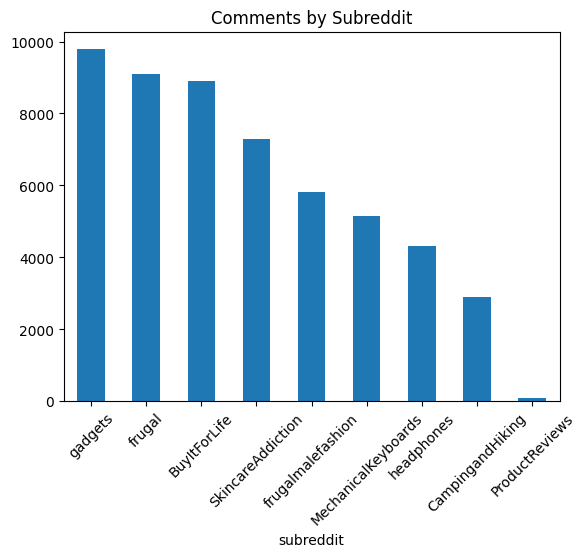

subreddit
gadgets                9787
frugal                 9088
BuyItForLife           8896
SkincareAddiction      7280
frugalmalefashion      5817
MechanicalKeyboards    5140
headphones             4317
CampingandHiking       2901
ProductReviews           84
Name: count, dtype: int64


In [7]:
subreddit_counts = df['subreddit'].value_counts()
subreddit_counts.plot(kind='bar')
plt.title("Comments by Subreddit")
plt.xticks(rotation=45)
plt.show()
print(subreddit_counts)

In [8]:
import json

# Your current stopwords set (paste the full set from the last code)
stopwords = {
    'the', 'i', 'a', 'to', 'and', 'it', 'of', 'you', 'that', 'for', 'is', 'in', 
    's', 'my', 't', 'but', 'on', 'have', 'this', 'with', 'be', 'are', 'was', 
    'were', 'at', 'by', 'an', 'as', 'do', 'did', 'can', 'will', 'would', 'could', 
    'should', 'me', 'he', 'she', 'we', 'they', 'him', 'her', 'us', 'them', 
    'not', 'no', 'or', 'so', 'up', 'out', 'if', 'than', 'from', 'what', 'when', 
    'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 
    'other', 'some', 'such', 'only', 'own', 'same', 'just', 'very', 'even', 
    'new', 'good', 'first', 'last', 'long', 'great', 'little', 'own', 'other', 
    'old', 'right', 'big', 'high', 'small', 'large', 'young', 'much', 'many', 
    'well', 'say', 'get', 'make', 'go', 'see', 'know', 'take', 'think', 'look', 
    'want', 'give', 'use', 'find', 'tell', 'ask', 'work', 'seem', 'feel', 'try', 
    'leave', 'call', 'come',
    'like', 'your', 'one', 'don', 'about', 'there', 'had', 'people', 'their', 
    'really', 'because', 'also', 'has', 'too', 'now', 'then', 'been', 'yeah', 
    'lol', 'haha', 'thing', 'things', 'way', 'going', 'got', 'said', 'oh', 
    'um', 'uh', 'ok', 'yes', 'no', 'time', 'years', 'still', 'does', 'better', 
    'these', 'which', 'something', 'never', 'used', 'those', 'into', 'best', 
    'here', 'after', 'over', 'back', 'every', 'days', 'weeks', 'months', 'least', 
    'second', 'third', 'next', 'before', 'during', 'while', 'until', 'through', 
    'around', 'again', 'always', 'often', 'sometimes', 'rarely', 'ever', 'once', 
    'twice', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 
    'being', 'made', 'though', 'sure', 'actually', 'pretty', 'using', 'anything', 
    'stuff', 'down', 'cannot', 'quite', 'kind', 'kinda', 'sort', 'type', 'lot', 
    'lots', 'bit', 'parts', 'end', 'ends', 'top', 'bottom', 'front', 'left', 
    'right', 'middle', 'center', 'full', 'half', 'whole', 'since', 'thanks', 
    'nice', 'someone', 'probably', 'maybe', 'thank', 'point', 'looking', 
    'different', 'post', 'getting', 'keep', 'might', 'enough', 'doing', 'looks', 
    'everything', 'year', 'life', 'less', 'without', 'ones', 'definitely', 'free',
    'another', 'having', 'thought'
}

# Your current contractions dict (paste the full dict from the last code)
contractions = {
    "don't": "do not", "ain't": "am not", "can't": "cannot", "couldn't": "could not",
    "didn't": "did not", "doesn't": "does not", "hadn't": "had not", "hasn't": "has not",
    "haven't": "have not", "isn't": "is not", "mightn't": "might not", "mustn't": "must not",
    "needn't": "need not", "shan't": "shall not", "shouldn't": "should not", "wasn't": "was not",
    "weren't": "were not", "won't": "will not", "wouldn't": "would not", "i'm": "i am",
    "you're": "you are", "he's": "he is", "she's": "she is", "it's": "it is", "we're": "we are",
    "they're": "they are", "i've": "i have", "you've": "you have", "we've": "we have",
    "they've": "they have", "i'd": "i would", "you'd": "you would", "he'd": "he would",
    "she'd": "she would", "we'd": "we would", "they'd": "they would", "i'll": "i will",
    "you'll": "you will", "he'll": "he will", "she'll": "she will", "we'll": "we will",
    "they'll": "they will"
}

# Write to JSON files (easy to load/edit)
with open('stopwords.json', 'w') as f:
    json.dump(list(stopwords), f)  # Convert set to list for JSON

with open('contractions.json', 'w') as f:
    json.dump(contractions, f)

print("Files created: stopwords.json and contractions.json")

Files created: stopwords.json and contractions.json


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pelic\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\pelic\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\pelic\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


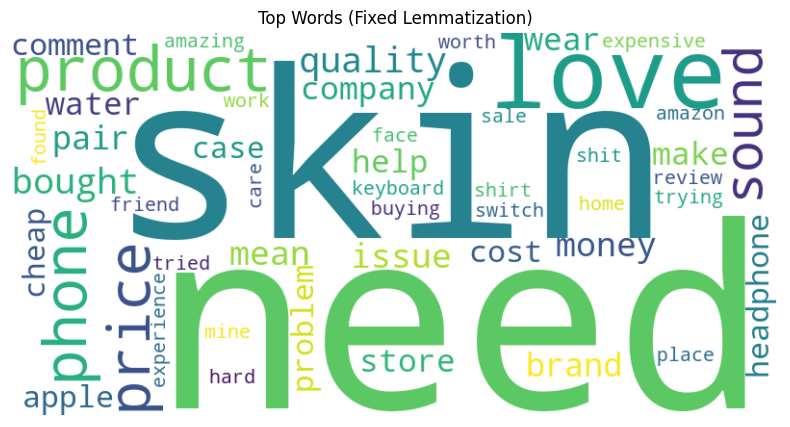

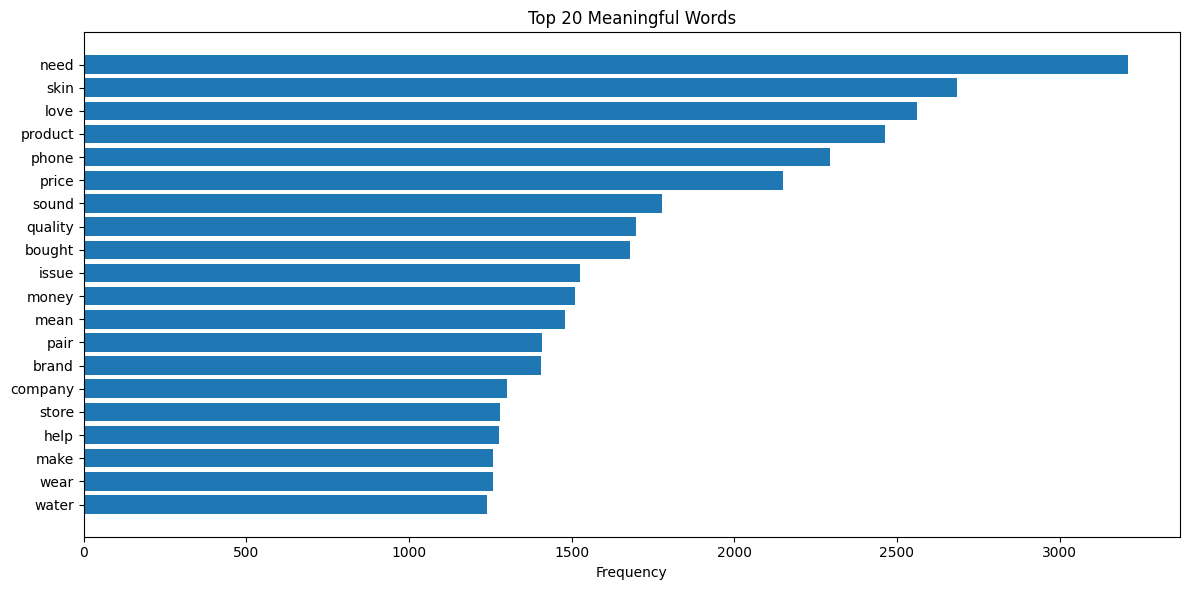

Top 20 meaningful words: [('need', 3210), ('skin', 2686), ('love', 2562), ('product', 2462), ('phone', 2295), ('price', 2151), ('sound', 1778), ('quality', 1697), ('bought', 1679), ('issue', 1527), ('money', 1509), ('mean', 1478), ('pair', 1408), ('brand', 1405), ('company', 1302), ('store', 1279), ('help', 1277), ('make', 1259), ('wear', 1257), ('water', 1241)]


In [9]:
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Load stopwords/contractions from files
with open('stopwords.json', 'r') as f:
    stopwords = set(json.load(f))

with open('contractions.json', 'r') as f:
    contractions = json.load(f)

# Download resources (non-quiet to see progress/errors)
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

def expand_contractions(text):
    for word in contractions:
        text = re.sub(r'\b' + word + r'\b', contractions[word], text, flags=re.IGNORECASE)
    return text

def get_wordnet_pos(word):
    try:
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)
    except LookupError:
        return wordnet.NOUN  # Fallback to noun if tagger missing

# Process text
all_text = ' '.join(df['cleaned'])
all_text = expand_contractions(all_text)
words = re.findall(r'\b\w+\b', all_text.lower())
filtered_words = [word for word in words if word not in stopwords and len(word) > 3]

# Lemmatization (with fallback)
lemmatizer = WordNetLemmatizer()
filtered_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in filtered_words]

common = Counter(filtered_words).most_common(50)

# Word cloud
wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(common))
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Top Words (Fixed Lemmatization)")
plt.show()

# Bar chart
top_20 = pd.DataFrame(common[:20], columns=['word', 'count'])
plt.figure(figsize=(12, 6))
plt.barh(top_20['word'], top_20['count'])
plt.xlabel('Frequency')
plt.title('Top 20 Meaningful Words')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 20 meaningful words:", common[:20])

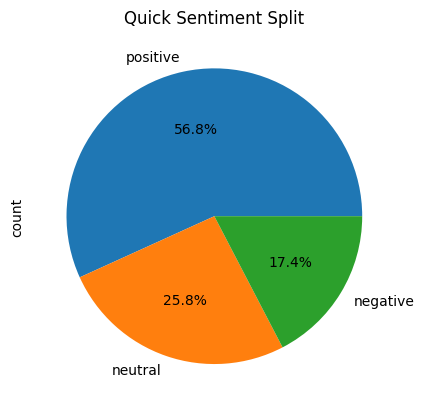

In [10]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
df['vader_score'] = df['cleaned'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df['vader_label'] = pd.cut(df['vader_score'], bins=[-1, -0.2, 0.2, 1], labels=['negative', 'neutral', 'positive'])
df['vader_label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Quick Sentiment Split")
plt.show()

In [ ]:
df['created_date'] = pd.to_datetime(df['created_utc']).dt.date
df.groupby('created_date').size().plot()
plt.title("Comments Over Time")
plt.show()